# **Extract data through Google API**

In [1]:
from call_ListGauges import get_ListGauges
from call_GetGaugeModel import get_GetGaugeModel
from plots_maps import map_gauge_coordinates_of_country

In [2]:
import os
from typing import List, Dict, Any
import json
import pandas as pd
import geopandas as gpd
from shapely import geometry
import requests
import pprint
import datetime
import matplotlib.pyplot as plt

# Delete dependencies later, keep them for now for experminetation

### **Goal:**

Make main() that takes as argument a country and generates a few .csv files with all data for all gauges in that country


##### **Steps**:
To get the data from the Google Bucket into workable format, we follow:
* Connect with the API
* **Expand this step!** Set-up pipeline which downloads all relevant data per country code
* Format the data into DateTime (y) and features (x)
* Store externally as .csv

##### **Background info -- API**
The API has three basic functions:
* *ListGauges*: Returns a list of supported gauges within a given country (code)
* *GetGaugeModel*: Returns model information of a specific gauge (within a given country, that is)
* *QueryGaugeForecasts*: Returns the forecasts of specific gauge

We'll create a pipeline going through these three functions, taking as input just the target country and outputting a DateTime-indexed .csv with all available forecasts for that country's available gauges. 

##### **(??? -> Maybe this is too much... A format which uses a list of matrices (an implicit tensor) where the matrices are just one gauge might be better. Either way, the metadata is best stored separately in a separate .csv. Choose adequate naming here.)**

For subsequent analysis, see ../analyse_data/

In [3]:
# Note: add this folder manually at the pointed path for the script to run
# For the key, ask the owner of the repository or try guessing
path_API_key = "../../data/keys/API_key.txt"

In [4]:
df_gauges_ML = get_ListGauges('Mali', path_API_key)

In [5]:
print(type(df_gauges_ML))
print(len(df_gauges_ML))
print(df_gauges_ML.columns)

<class 'pandas.core.frame.DataFrame'>
16
Index(['siteName', 'source', 'river', 'gaugeId', 'qualityVerified', 'latitude',
       'longitude'],
      dtype='object')


In [6]:
print(df_gauges_ML.head(2))

  siteName source      river           gaugeId  qualityVerified   latitude  \
0           HYBAS  Sankarani  hybas_1120766460             True  11.222917   
1           HYBAS             hybas_1120689830             True  13.210417   

   longitude  
0  -8.485417  
1  -7.077083  


In [9]:
def print_country_gauge_coords(df_gauges: pd.DataFrame, country_name: str) -> None:
    """
    Print the gauge names and coordinates of a specific country

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    """
    df_subset = df_gauges.set_index('gaugeId')[['latitude', 'longitude']]

    print(f"Coordinates of gauges in {country_name}")
    print(df_subset)


print_country_gauge_coords(df_gauges_ML, 'Mali')

Coordinates of gauges in Mali
                   latitude  longitude
gaugeId                               
hybas_1120766460  11.222917  -8.485417
hybas_1120689830  13.210417  -7.077083
hybas_1120641660  14.506250  -4.206250
hybas_1120661040  13.985417  -7.152083
hybas_1120650110  14.277083  -6.927083
hybas_1121893090  14.131250  -5.039583
hybas_1120758950  11.427083  -6.581250
hybas_1120739110  11.977083  -6.360417
hybas_1120679780  13.493750  -6.202083
hybas_1121895840  13.956250  -5.360417
hybas_1121900350  13.685417  -5.893750
hybas_1121905290  13.360417  -6.789583
hybas_1121890140  14.314583  -4.422917
hybas_1120705070  12.835417  -7.581250
hybas_1120737100  12.018750  -8.322917
hybas_1121919510  12.410417  -8.106250


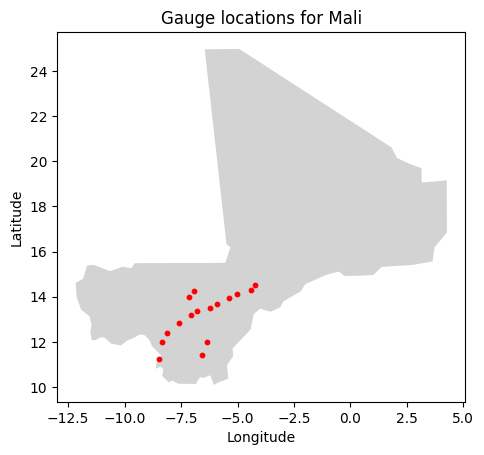

In [7]:
map_gauge_coordinates_of_country(df_gauges_ML, 'Mali')

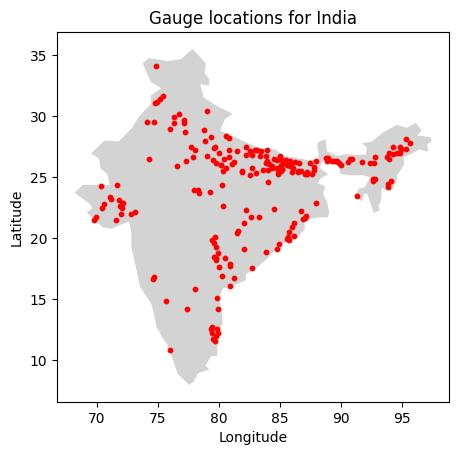

In [8]:
map_gauge_coordinates_of_country(
    get_ListGauges(
        'India', path_API_key
        ), 'India'
    )

### **Testing the GetGaugeModel and QueryGaugeForecasts calls:**

In [10]:
df_gauge_models_ML = get_GetGaugeModel(path_API_key, df_gauges_ML)
print(type(df_gauge_models_ML))
print(len(df_gauge_models_ML))
print(df_gauge_models_ML.head(2))

<class 'pandas.core.frame.DataFrame'>
16
            gaugeId           gaugeValueUnit  qualityVerified  dangerLevel  \
0  hybas_1120758950  CUBIC_METERS_PER_SECOND             True   729.448914   
1  hybas_1120661040  CUBIC_METERS_PER_SECOND             True   100.935829   

   extremeDangerLevel  warningLevel  
0          919.753723    554.390076  
1          192.571655     52.250954  


In [31]:
from getters import get_API_key

from typing import List, Dict, Any
import pandas as pd
import requests
import datetime


# def generate_url_QueryGaugeForecasts(
#         path_API_key: str, gauge_ids: List[str], interval: tuple) -> str:
#     """
#     Generate the URL for the QueryGaugeForecasts API call
    
#     :param path_API_key: path to the file containing the API key
#     :param gauge_ids: list of gauge IDs
#     :param interval: tuple of two datetime objects
#     :return: URL for the API call
#     """
#     return (
#         f'https://floodforecasting.googleapis.com/v1/gauges:queryGaugeForecasts'
#         f'?key={get_API_key(path_API_key)}'
#         f'&gaugeIds={",".join(gauge_ids) if isinstance(gauge_ids, list) else gauge_ids}'
#         f'&issuedTimeStart={interval[0].strftime("%Y-%m-%d")}'
#         f'&issuedTimeEnd={interval[1].strftime("%Y-%m-%d")}'
#     )


# # def make_request_QueryGaugeForecasts(
# #         path_API_key: str, gauge_ids: List[str], interval: tuple) -> Any:
# #     """
# #     Make the QueryGaugeForecasts API call
    
# #     :param path_API_key: path to the file containing the API key
# #     :param gauge_ids: list of gauge IDs
# #     :param interval: tuple of two datetime objects
# #     :return response: response from the API call
# #     """
# #     return requests.get(
# #         generate_url_QueryGaugeForecasts(path_API_key, gauge_ids, interval)
# #     )


def make_request_QueryGaugeForecasts(
        path_API_key: str, gauge_ids: List[str], interval: tuple) -> Any:
    """
    Make the QueryGaugeForecasts API call
    
    :param path_API_key: path to the file containing the API key
    :param gauge_ids: list of gauge IDs
    :param interval: tuple of two datetime objects
    :return response: response from the API call
    """
    return requests.get(
            f'https://floodforecasting.googleapis.com/v1/gauges:queryGaugeForecasts',
            params = {
                'key': get_API_key(path_API_key),
                'gaugeIds': gauge_ids,
                'issuedTimeStart': interval[0].strftime("%Y-%m-%d"),
                'issuedTimeEnd': interval[1].strftime("%Y-%m-%d"),
            },
        )


def verify_response_QueryGaugeForecasts(response: Any) -> Any:
    """
    Verify the response from the QueryGaugeForecasts API call
    
    :param response: response from the API call
    :return: True if the response is valid, False otherwise
    """
    if response.status_code != 200:
        raise Exception(f'Error: {response.status_code} -- {response.text}')

    try:
        return response.json()['forecasts']
    except ValueError as exc:
        raise Exception(f'Error parsing .json: {exc} -- {response.text}')
    

def convert_QueryGaugeForecasts_to_df(response: Dict[str, Dict[str, List[Any]]]) -> List[pd.DataFrame]:
    """
    Convert the response from the QueryGaugeForecasts API call to DataFrame(s)
    
    :param response: response from the API call
    :return: DataFrame !TODO Maak de DataFrame netjes!!!!
    """
    #!!! Fill in !!!!!!

    return pd.DataFrame(response)


def get_QueryGaugeForecasts(
        path_API_key: str, gauge_ids: List[str], interval: tuple) -> List[pd.DataFrame]:
    """
    Get the QueryGaugeForecasts API call, which returns:
    - for every gauge in gauge_ids, the forecasts for the given interval, which contain:
        - the forecasted values
        - the forecasted times
        !!! Dit mag ook nog aangevuld worden
    
    :param path_API_key: path to the file containing the API key
    :param gauge_ids: list of gauge IDs
    :param interval: tuple of two datetime objects
    :return: DataFrame
    """
    return convert_QueryGaugeForecasts_to_df(
        verify_response_QueryGaugeForecasts(
            make_request_QueryGaugeForecasts(path_API_key, gauge_ids, interval)
        )
    )
    

In [32]:
last_week = datetime.datetime.now() - datetime.timedelta(days = 7)
tomorrow = datetime.datetime.now() + datetime.timedelta(days = 1)

pprint.pprint(
    verify_response_QueryGaugeForecasts(
        make_request_QueryGaugeForecasts(
            path_API_key, df_gauges_ML['gaugeId'].tolist()[0], 
            (last_week, tomorrow)
        )
    )
)

{'hybas_1121890140': {'forecasts': [{'forecastRanges': [{'forecastEndTime': '2024-09-21T00:00:00Z',
                                                         'forecastStartTime': '2024-09-21T00:00:00Z',
                                                         'value': 3134.018798828125},
                                                        {'forecastEndTime': '2024-09-22T00:00:00Z',
                                                         'forecastStartTime': '2024-09-22T00:00:00Z',
                                                         'value': 3043.222412109375},
                                                        {'forecastEndTime': '2024-09-23T00:00:00Z',
                                                         'forecastStartTime': '2024-09-23T00:00:00Z',
                                                         'value': 3013.31884765625},
                                                        {'forecastEndTime': '2024-09-24T00:00:00Z',
                                     